In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [62]:
!pip install imbalanced-learn shap

  Using cached shap-0.50.0-cp313-cp313-win_amd64.whl.metadata (25 kB)
Using cached shap-0.50.0-cp313-cp313-win_amd64.whl (549 kB)


In [63]:
from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings('ignore')


In [64]:
df = pd.read_csv("german_credit_data.csv")

df.head()


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [65]:

df.drop(columns=["Unnamed: 0"], inplace=True)

df["Saving accounts"].fillna("No Account", inplace=True)
df["Checking account"].fillna("No Account", inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB


In [66]:

df["Risk"] = df["Risk"].map({"good": 0, "bad": 1})
df = pd.get_dummies(df, drop_first=True)
df.head()


,Age,Job,Credit amount,Duration,Risk,Sex_male,Housing_own,Housing_rent,Saving accounts_little,Saving accounts_moderate,...,Checking account_little,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,2,1169,6,0,True,True,False,False,False,...,True,False,False,False,False,False,False,True,False,False
1,22,2,5951,48,1,False,True,False,True,False,...,False,True,False,False,False,False,False,True,False,False
2,49,1,2096,12,0,True,True,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,45,2,7882,42,0,True,False,False,True,False,...,True,False,False,False,False,False,True,False,False,False
4,53,2,4870,24,1,True,False,False,True,False,...,True,False,False,True,False,False,False,False,False,False


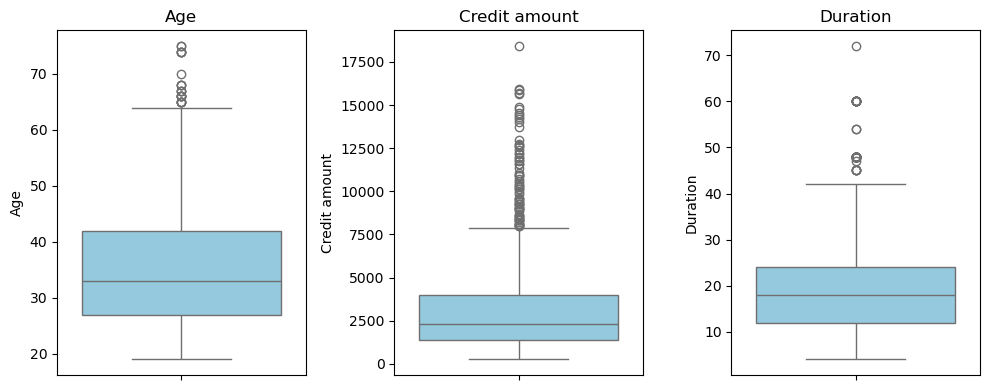

In [67]:
plt.figure(figsize=(10,4))
for i, col in enumerate(['Age','Credit amount', 'Duration']):
  plt.subplot(1,3,i+1)
  sns.boxplot(y=df[col],color='skyblue')
  plt.title(col)
plt.tight_layout()
plt.show()

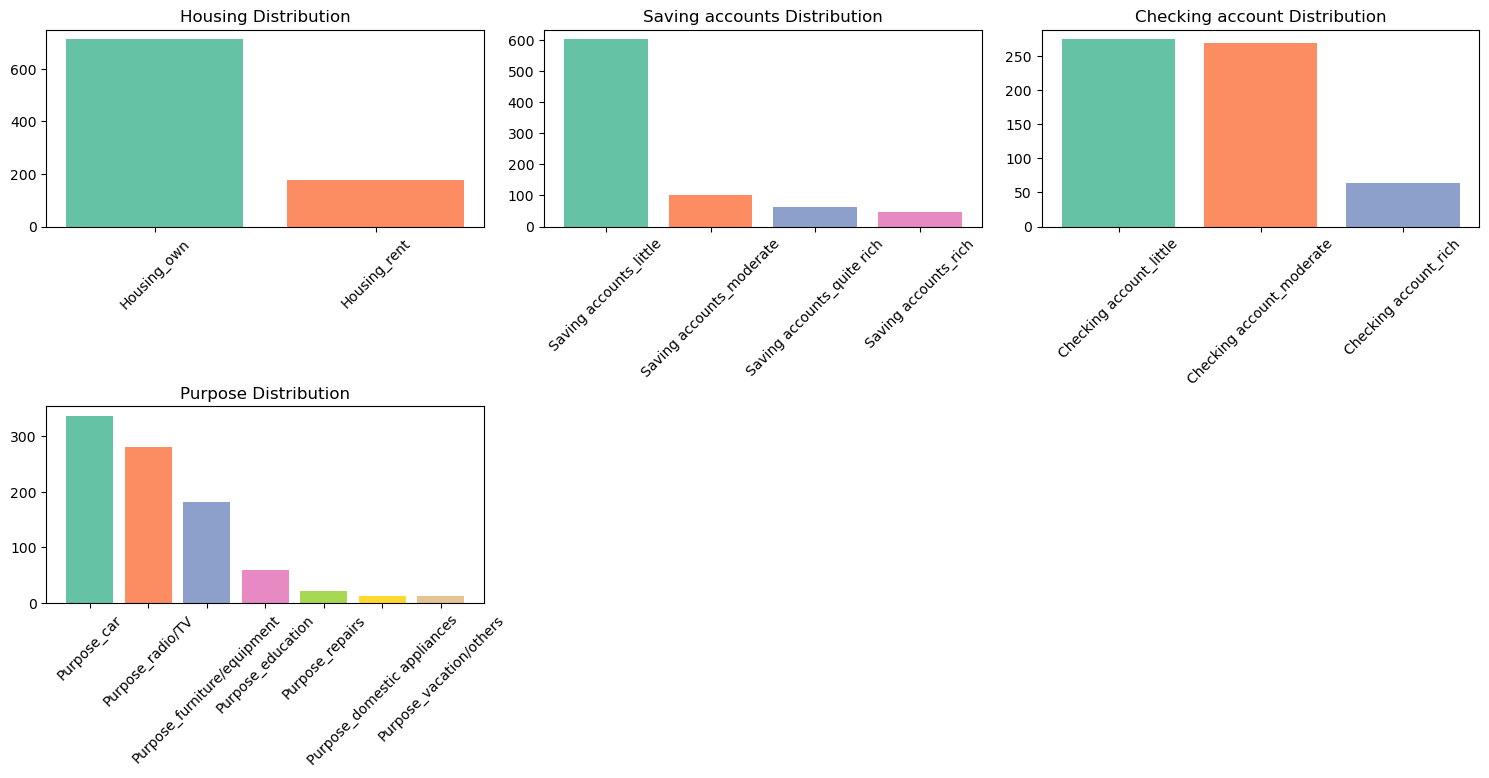

In [78]:

categorical_prefixes = [ 'Job_', 'Housing_', 
                        'Saving accounts_', 'Checking account_', 'Purpose_']

plt.figure(figsize=(15, 10))

plot_index = 1
palette = sns.color_palette("Set2")  # You can change this

for prefix in categorical_prefixes:
    cols = [col for col in df.columns if col.startswith(prefix)]
    
    if cols:
        plt.subplot(3, 3, plot_index)
        
        values = df[cols].sum().sort_values(ascending=False)
        colors = palette[:len(values)]
        
        plt.bar(values.index, values.values, color=colors)
        plt.title(f"{prefix.replace('_','')} Distribution")
        plt.xticks(rotation=45)
        
        plot_index += 1

plt.tight_layout()
plt.show()


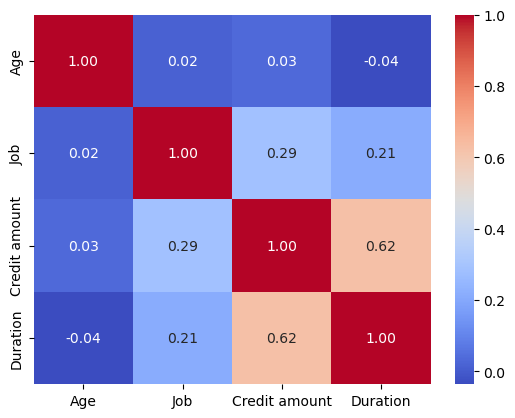

In [79]:
corr=df[['Age','Job',"Credit amount",'Duration']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [ ]:
X = df.drop("Risk", axis=1)
y = df["Risk"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training shape:", X_train.shape)


Training shape: (800, 21)


In [ ]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_sm.value_counts())


Before SMOTE: Risk
0    560
1    240
Name: count, dtype: int64
After SMOTE: Risk
1    560
0    560
Name: count, dtype: int64


In [ ]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_sm, y_train_sm)

y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:,1]

print("Logistic Regression Results")
print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log))


Logistic Regression Results
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       140
           1       0.52      0.45      0.48        60

    accuracy                           0.71       200
   macro avg       0.65      0.64      0.64       200
weighted avg       0.70      0.71      0.70       200

ROC-AUC: 0.7175


In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_sm, y_train_sm)

y_pred_dt = dt_model.predict(X_test)
y_prob_dt = dt_model.predict_proba(X_test)[:,1]

print("Decision Tree Results")
print(classification_report(y_test, y_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_dt))


Decision Tree Results
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       140
           1       0.38      0.38      0.38        60

    accuracy                           0.63       200
   macro avg       0.56      0.56      0.56       200
weighted avg       0.63      0.63      0.63       200

ROC-AUC: 0.5595238095238095


In [ ]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_sm, y_train_sm)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:,1]

print("Random Forest Results")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


Random Forest Results
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       140
           1       0.45      0.35      0.39        60

    accuracy                           0.68       200
   macro avg       0.60      0.58      0.59       200
weighted avg       0.66      0.68      0.66       200

ROC-AUC: 0.6810119047619048


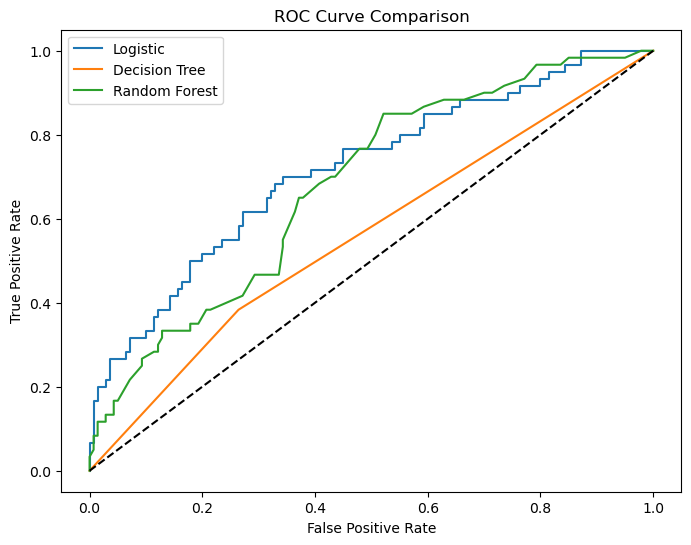

In [ ]:
plt.figure(figsize=(8,6))

fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.plot(fpr_log, tpr_log, label="Logistic")
plt.plot(fpr_dt, tpr_dt, label="Decision Tree")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


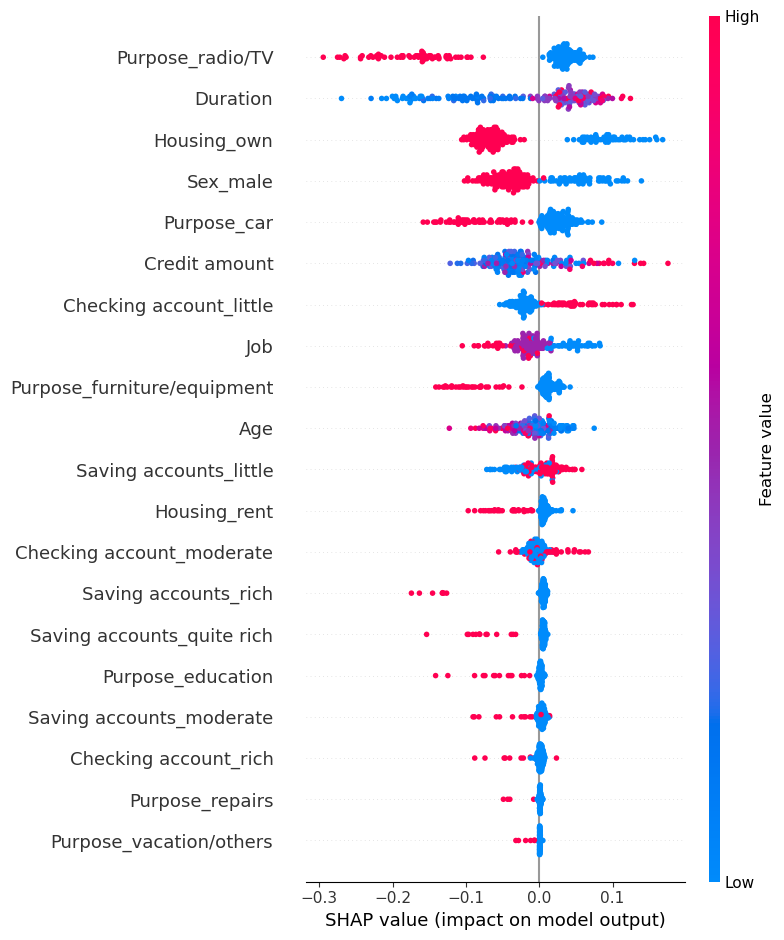

In [ ]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values.values[:, :, 1], X_test)


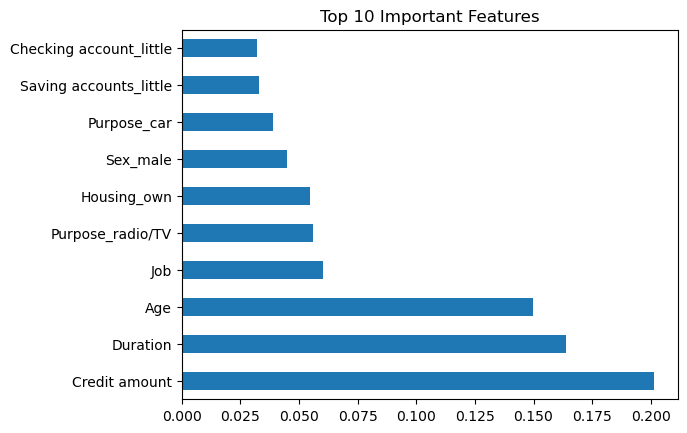

In [ ]:
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.show()


In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid.fit(X_train_sm, y_train_sm)

print("Best Parameters:", grid.best_params_)


Best Parameters: {'max_depth': 20, 'n_estimators': 100}


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.75      0.81      0.78       140
           1       0.45      0.35      0.39        60

    accuracy                           0.68       200
   macro avg       0.60      0.58      0.59       200
weighted avg       0.66      0.68      0.66       200



In [ ]:
y_prob = rf_model.predict_proba(X_test)[:,1]

threshold = 0.4
y_pred_custom = (y_prob > threshold).astype(int)

print(classification_report(y_test, y_pred_custom))


              precision    recall  f1-score   support

           0       0.74      0.66      0.70       140
           1       0.37      0.47      0.41        60

    accuracy                           0.60       200
   macro avg       0.56      0.57      0.56       200
weighted avg       0.63      0.60      0.62       200

